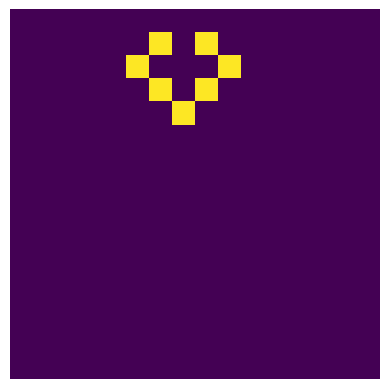

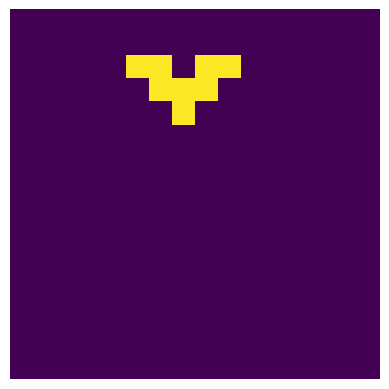

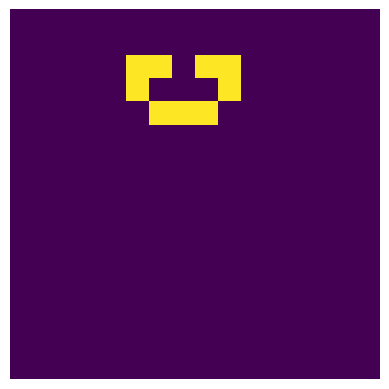

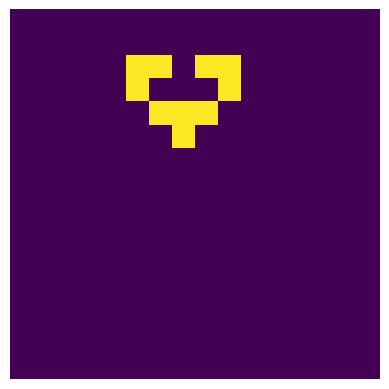

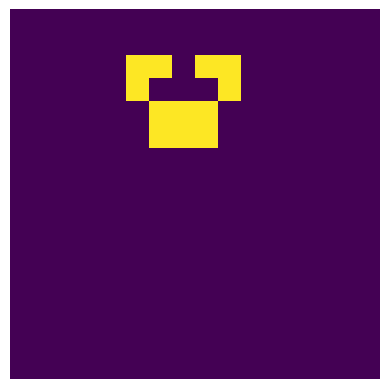

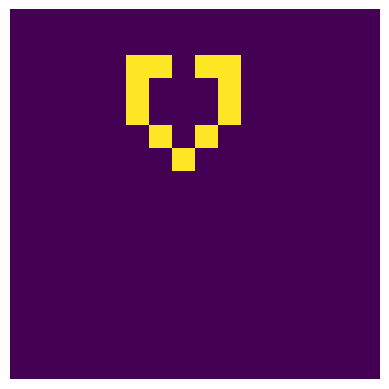

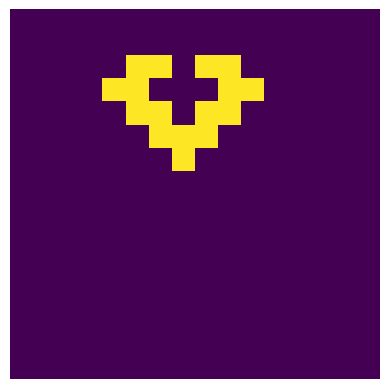

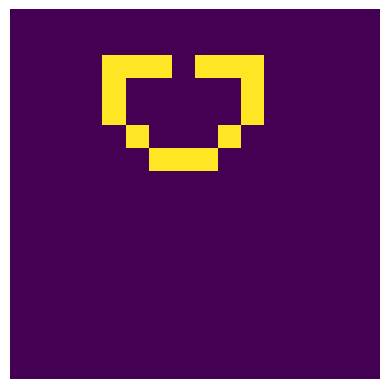

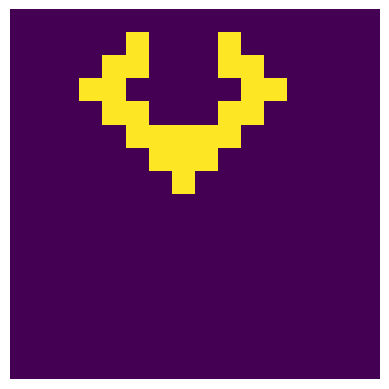

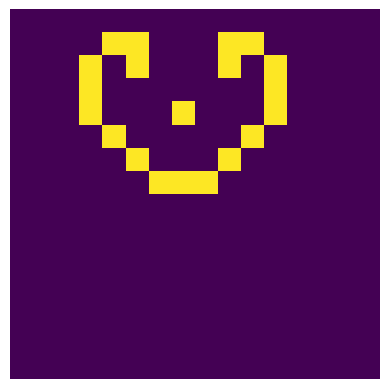

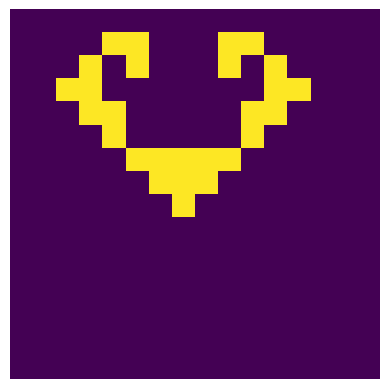

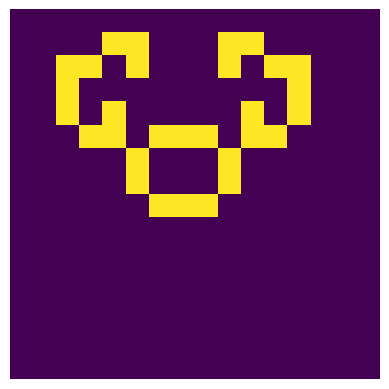

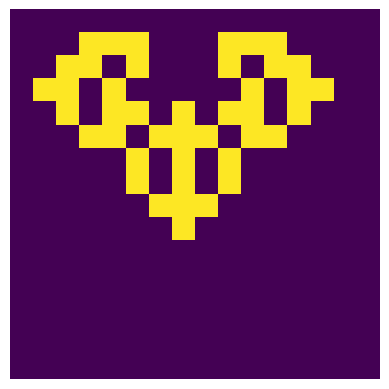

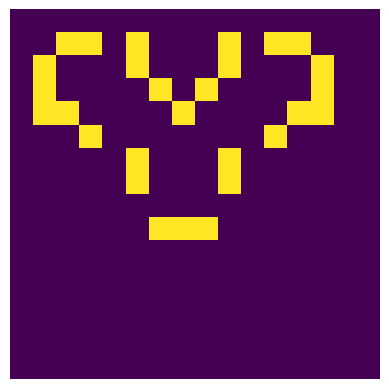

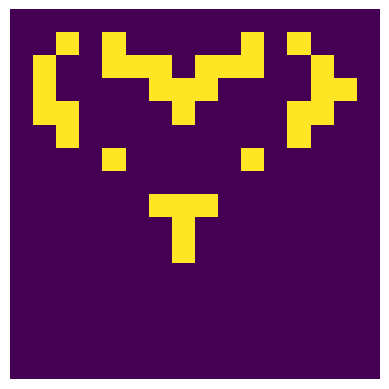

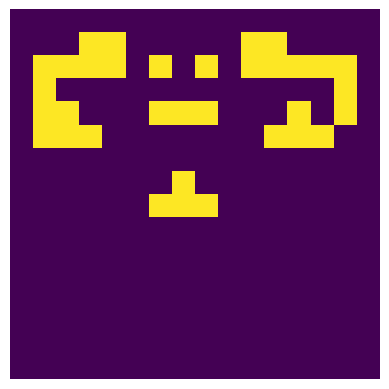

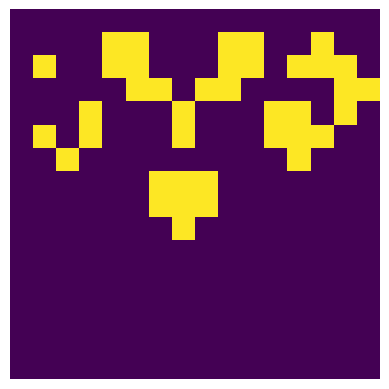

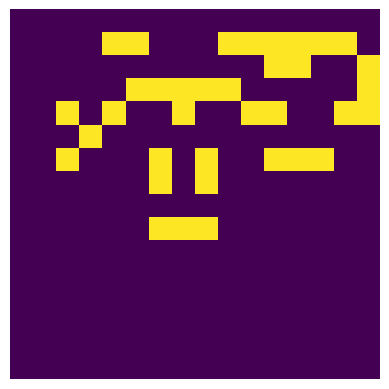

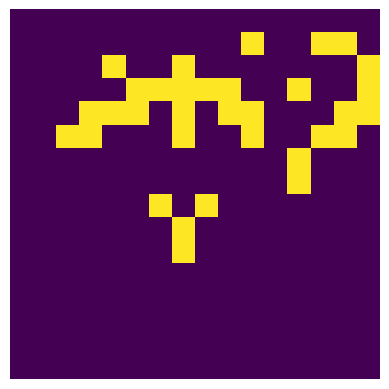

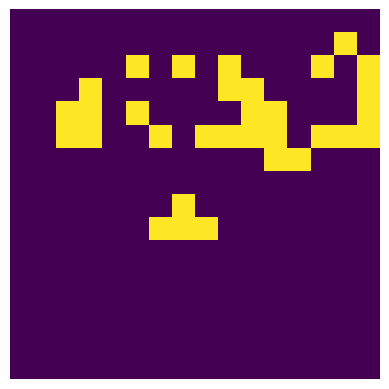

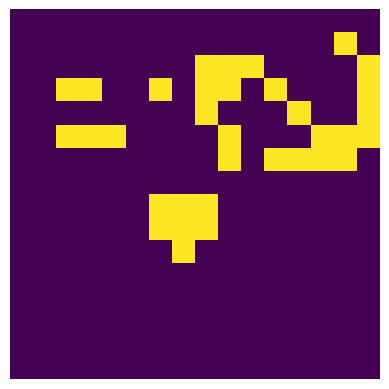

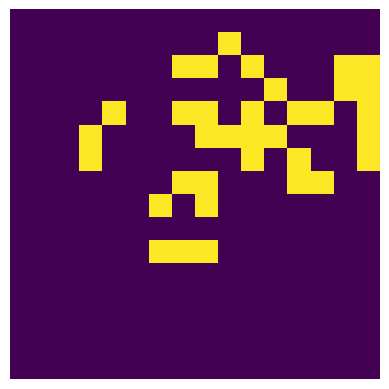

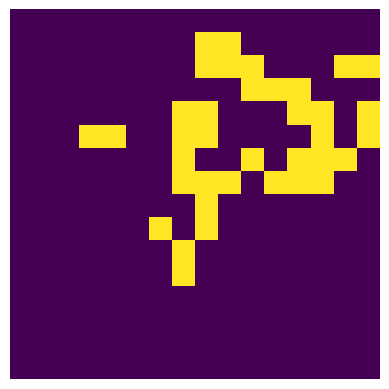

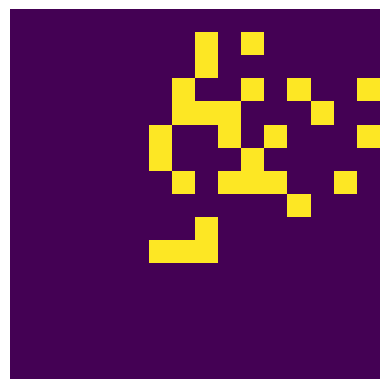

KeyboardInterrupt: 

In [20]:
from pysmt.shortcuts import *
import pysmt.typing as types
import numpy as np
import random as rn
import matplotlib.pyplot as plt
from functools import reduce

n = 16     # dimensão do espaço de amostras
m = 64     # numero de amostras
p = 0
# Escolha de "solver"
#name = "msat"
name = "z3"

def print_state(s):
    x = list(map(int, list(s.bv_str())))
    x = [x[i:i + n] for i in range(0, len(x), n)]
    plt.imshow(x)
    plt.axis('off')
    plt.show()

# Funções auxiliares para BitVec's
def bv_rn():       # gera pseudo-aleatoriamente um BitVec para representar o autómato, a partir de um inteiro
    I = 0
    J = 0
    c_x = np.random.randint(1, n-2)
    c_y = np.random.randint(1, n-2)
    for i in range(n-1):
        I = I | np.random.binomial(1,p) * 2**(i + n*(n-1))
        I = I | np.random.binomial(1,p) * 2**(n*i+n-1)
    I = I | np.random.binomial(1,p) * 2**(n*n-1)
    J = I
    for i in range(c_x-1, c_x+2):
        for j in range(c_y-1, c_y+2):
            I = I | 2**(i+j*n)
    return (BV(I,n*n), BV(J,n*n))

#vai ser preciso definir isto dentro do modelo, provavelmente. 
#Conseguir gerar mais que um e um número máximo de iterações para tentar provar as proprieadas
#Tentar gerar contra exemplos para as expressões ditas (sei que são falsas)

def bv_selZE(z,i,j):                    # seleciona o bit (i,j) do BitVec "z" e estende n*n-1
    return BVZExt(BVExtract(z,start=i+j*n,end=i+j*n),n*n-1)

def bv_sel(z,i,j):                    # seleciona o bit (i,j) do BitVec "z"
    return BVExtract(z,start=i+j*n,end=i+j*n)

def declare(i): #declara um bitvector de tamanho n*n
    state = Symbol('s'+str(i),types.BVType(n*n))
    return state

def trans(curr, prox): #define uma transição entre dois estados do problema
    r = []
    for i in range(n):
        r.append(Equals(bv_sel(prox,i,n-1), bv_sel(border,i,n-1)))
        r.append(Equals(bv_sel(prox,n-1,i), bv_sel(border,n-1,i)))
    for i in range(n-1):
        for j in range(n-1):
            #t0 = And(Equals(bv_sel(next,i,j), Int(0)), E)
            #prox[i][j] == 1 sse curr[i][j] == 1 e s == 4 ou s == 3
            s = sum([bv_selZE(curr,a,b) for a in [i-1,i,i+1] for b in [j-1,j,j+1] if a >= 0 and a < n and b >= 0 and b < n])
            t1 = Iff(Equals(bv_sel(prox,i,j), BVOne(1)), Or(Equals(s, BV(3,n*n)), And(Equals(bv_sel(curr,i,j),BVOne(1)), Equals(s, BV(4,n*n)))))
            r.append(t1)
    return And(r)

def generate_trace(initial, p=True):
    with Solver(name=name) as solver:
        i = 0
        last = initial
        trace = {}
        while last not in trace:
            trace[last] = i
            i += 1
            prox = declare(len(trace))
            solver.push()
            solver.add_assertion(trans(last, prox))
            if not solver.solve():
                print("Algo deu asneira.")
                break
            last = solver.get_value(prox)
            if p:
                print_state(last)
            solver.pop()
        return trace

with Solver(name=name) as solver:
    initial, border = bv_rn()
    trace = generate_trace(initial)
    solver.push()    
    #state é uma constante de BitVector
    for state in trace:
        solver.add_assertion(Not(Equals(state, border)))
    if solver.solve():
        print(solver.get_model())
        print("Todos os estados têm pelo menos uma célula viva.")
    else:
        print("Existe um estado sem células vivas.")
    solver.pop()
    #fazer o OR lógico de todos os bitvectors e ver se é igual ou diferente de BVZero(n*n)
    solver.push()
    solver.add_assertion(Equals(reduce(BVOr, list(trace)), BVNot(border)))
    if solver.solve():
        print("Todas as células estiveram vivas pelo menos uma vez.")
    else:
        print("Existem células que não ficaram vivas.")
    solver.pop()

In [22]:
with Solver(name=name) as solver:
    visited = set()
    #state é uma constante de BitVector
    initial, border = bv_rn()
    visited.add(initial)
    trace = generate_trace(initial,False)
    solver.push()
    solver.add_assertion(Or([Equals(state, border) for state in trace]))
    while not solver.solve():
        print("Todos os estados têm pelo menos uma célula viva.")    
        solver.pop()
        initial, border = bv_rn()
        #possivelmente contar quantas vezes se fez para se exaustar, ou até manter cuidado com o tamanho de visited
        while initial in visited:
            initial, border = bv_rn()
        visited.add(initial)
        trace = generate_trace(initial,p=False)
        solver.push()
        solver.add_assertion(Or([Equals(state, border) for state in trace]))
    print("Existe um estado que não tem uma célula viva.")
    print(solver.get_model())
    solver.pop()
    
    #fazer o OR lógico de todos os bitvectors e ver se é igual ou diferente de BVZero(n*n)
    solver.push()
    solver.add_assertion(Not(Equals(reduce(BVOr, list(trace)), BVNot(border))))
    while not solver.solve():
        print("Todas as células estiveram vivas pelo menos uma vez.")    
        solver.pop()
        initial, border = bv_rn()
        #possivelmente contar quantas vezes se fez para se exaustar, ou até manter cuidado com o tamanho de visited
        while initial in visited:
            initial, border = bv_rn()
        visited.add(initial)
        trace = generate_trace(initial,p=False)
        solver.push()
        solver.add_assertion(Not(Equals(reduce(BVOr, list(trace)), BVNot(border))))
    print("Existe uma célula que não esteve viva.")
    print(solver.get_model())
    solver.pop()

Todos os estados têm pelo menos uma célula viva.
Todos os estados têm pelo menos uma célula viva.
Todos os estados têm pelo menos uma célula viva.
Todos os estados têm pelo menos uma célula viva.
Todos os estados têm pelo menos uma célula viva.
Existe um estado que não tem uma célula viva.

Existe uma célula que não esteve viva.

